# Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import lalsimulation as lal
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import keras
import keras_metrics as km
import keras
import keras_metrics as km
from keras import metrics

2023-07-27 15:21:36.605878: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
gamma0 = np.loadtxt("test_gamma_0.dat", dtype=float)
gamma1 = np.loadtxt("test_gamma_1.dat", dtype=float)
gamma2 = np.loadtxt("test_gamma_2.dat", dtype=float)
l1 = np.loadtxt('test_lambda_1.dat', dtype=float)
l2 = np.loadtxt('test_lambda_2.dat', dtype=float)
logp1_cgs = np.loadtxt("test_logp1_cgs.dat", dtype=float)
logp2_cgs = np.loadtxt("test_logp2_cgs.dat", dtype=float)
m1 = np.loadtxt("test_mass_1.dat", dtype=float)
m2 = np.loadtxt("test_mass_2.dat", dtype=float)

In [160]:
len(m2)

541

In [3]:
logp1_s = logp1_cgs - 1
logp2_s = logp2_cgs - 1

# Functions

In [162]:
#formatting array & processing outputs

def format_output(data):
    gamma0 = data.pop('gamma0')
    gamma0 = np.array(gamma0)
    gamma1 = data.pop('gamma1')
    gamma1 = np.array(gamma1)
    gamma2 = data.pop('gamma2')
    gamma2 = np.array(gamma2)
    logp1_si = data.pop('logp1_si')
    logp1_si = np.array(logp1_si)
    logp2_si = data.pop('logp2_si')
    logp2_si = np.array(logp2_si)
    return gamma0, gamma1, gamma2, logp1_si, logp2_si



In [163]:
#normalize and save the new array, and the max

def minmax(inputarray):
    
    absinput = np.abs(inputarray)
    gmax = absinput.max()
    newarray = inputarray / gmax
                
    return newarray, gmax


In [164]:
#return inputs back to original values in order to plot EOS

def unnorm(predictionsarray, gam0max, gam1max, gam2max, logp1max, logp2max):
    
    for i in range (len(predictionsarray)):
        new_gamma0_array = predictionsarray[0] * gam0max
        new_gamma1_array = predictionsarray[1] * gam1max
        new_gamma2_array = predictionsarray[2] * gam2max
        new_logp1_array = predictionsarray[3] *  logp1max
        new_logp2_array = predictionsarray[4] *  logp2max
    
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, new_logp1_array, new_logp2_array), axis=1)

    return new_array

# MLA

In [165]:
# not normalized

#l1_dat = (l1)
#l2_dat = (l2)
#m1_dat = (m1)
#m2_dat = (m2)

#sd_gamma0 = (gamma0)
#sd_gamma1 = (gamma1)
#sd_gamma2 = (gamma2)
#logp1_si  = (logp1_s)
#logp2_si  = (logp2_s)

In [166]:
#normalizing inputs and outputs

l1_dat, l1max = minmax(l1)
l2_dat, l2max = minmax(l2)
m1_dat, m1max = minmax(m1)
m2_dat, m2max = minmax(m2)


sd_gamma0, gam0max = minmax(gamma0)
sd_gamma1, gam1max = minmax(gamma1)
sd_gamma2, gam2max = minmax(gamma2)
logp1_si, logp1max = minmax(logp1_s)
logp2_si, logp2max = minmax(logp2_s)


In [167]:
#create an empty array 8 x length(m1_dat]) for vals
array_size =  np.array([[0] * 9 ] * len(sd_gamma0))
array_size = array_size.astype('float64')
combined_array = np.zeros_like(array_size)
print(combined_array.dtype)
print(combined_array.shape)

float64
(541, 9)


In [168]:
#reformat data files into this new array
for i in range(0,len(m1_dat)-1):
    combined_array[i][0] = m1_dat[i]
    combined_array[i][1] = m2_dat[i]
    combined_array[i][2] = l1_dat[i]
    combined_array[i][3] = l2_dat[i]
    combined_array[i][4] = sd_gamma0[i]
    combined_array[i][5] = sd_gamma1[i]
    combined_array[i][6] = sd_gamma2[i]
    combined_array[i][7] = logp1_si[i]
    combined_array[i][8] = logp2_si[i]
    

In [169]:
data = pd.DataFrame(combined_array)
data.columns = ['m1','m2', 'l1', 'l2','gamma0', 'gamma1', 'gamma2', 'logp1_si', 'logp2_si']
print(data)

           m1        m2        l1        l2    gamma0    gamma1    gamma2  \
0    0.218650  0.193015  0.153056  0.251460  0.719947  0.796506  0.538981   
1    0.604057  0.615403  0.000326  0.000517  0.704915  0.990652  0.430400   
2    0.208787  0.158126  0.093318  0.370141  0.584126  0.230005  0.665380   
3    1.000000  0.848389  0.000031  0.000313  0.999251  0.788348  0.699867   
4    0.592996  0.386206  0.001469  0.016666  0.901590  0.640767  0.684007   
..        ...       ...       ...       ...       ...       ...       ...   
536  0.517025  0.578419  0.002012  0.001275  0.774422  0.935749  0.596484   
537  0.228841  0.192215  0.000391  0.002166  0.323060  0.688684  0.588188   
538  0.232140  0.168179  0.070740  0.303281  0.598414  0.827410  0.475309   
539  0.412878  0.453858  0.010270  0.006537  0.854197  0.840344  0.749463   
540  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

     logp1_si  logp2_si  
0    0.938916  0.944321  
1    0.959632  0.972747

In [170]:
#split data into train and test

data = data.sample(frac=1).reset_index(drop=True)

train, test = train_test_split(data, test_size=0.2)

print(train)

train_stats = train.describe()

#get gamma as the outputs and format them as np arrays.

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('logp1_si')
train_stats.pop('logp2_si')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

           m1        m2        l1        l2    gamma0    gamma1    gamma2  \
189  0.229227  0.274812  0.022144  0.009197  0.512157  0.481112  0.547643   
221  0.343225  0.304800  0.000204  0.002836  0.484832  0.953265  0.569627   
87   0.526792  0.367405  0.000413  0.010344  0.787153  0.552213  0.348413   
387  0.706768  0.687600  0.000514  0.000830  0.881605  0.920997  0.641251   
15   0.238320  0.252080  0.090897  0.067621  0.646502  0.851287  0.690015   
..        ...       ...       ...       ...       ...       ...       ...   
124  0.209890  0.247058  0.241787  0.106697  0.917603  0.562731  0.685110   
480  0.434062  0.410978  0.002226  0.005641  0.663005  1.000000  0.725400   
277  0.393673  0.417109  0.013737  0.010353  0.860662  0.200123  0.541951   
319  0.361906  0.386305  0.002940  0.002836  0.516196  0.993219  0.705148   
341  0.526592  0.237558  0.003462  0.148794  0.891098  0.974621  0.651733   

     logp1_si  logp2_si  
189  0.928045  0.945398  
221  0.972869  0.992912

In [171]:
norm_train_X = train
norm_test_X = test

In [172]:

input_layer = Input(shape=(len(train .columns),))

first_dense = Dense(units='128', activation='tanh')(input_layer)
second_dense = Dense(units='128', activation='tanh')(first_dense)
third_dense = Dense(units='128', activation='tanh')(second_dense)
fourth_dense = Dense(units='128', activation='tanh')(third_dense)
fifth_dense = Dense(units='128', activation='tanh')(fourth_dense)
sixth_dense = Dense(units='128', activation='tanh')(fifth_dense)
seventh_dense = Dense(units='128', activation='tanh')(sixth_dense)
eight_dense = Dense(units='128', activation='tanh')(seventh_dense)
ninth_dense = Dense(units='128', activation='tanh')(eight_dense)
    
tenth_dense = Dense(units='128', activation='tanh')(ninth_dense)
eleventh_dense = Dense(units='128', activation='tanh')(tenth_dense)
twelth_dense = Dense(units='128', activation='tanh')(eleventh_dense)
thirteenth_dense = Dense(units='128', activation='tanh')(twelth_dense)
fourteenth_dense = Dense(units='128', activation='tanh')(thirteenth_dense)
fifteenth_dense = Dense(units='128', activation='tanh')(fourteenth_dense)
sixteenth_dense = Dense(units='128', activation='tanh')(fifteenth_dense)
seventeenth_dense = Dense(units='128', activation='tanh')(sixteenth_dense)
eighteenth_dense = Dense(units='128', activation='tanh')(seventeenth_dense)
nineteenth_dense = Dense(units='128', activation='tanh')(eighteenth_dense)
    
twentieth_dense = Dense(units='128', activation='tanh')(nineteenth_dense)
tf_dense = Dense(units='128', activation='tanh')(twentieth_dense)
ts_dense = Dense(units='128', activation='tanh')(tf_dense)
tt_dense = Dense(units='128', activation='tanh')(ts_dense)
tfo_dense = Dense(units='128', activation='tanh')(tt_dense)
tfi_dense = Dense(units='128', activation='tanh')(tfo_dense)
ts_dense = Dense(units='128', activation='tanh')(tfi_dense)
tse_dense = Dense(units='128', activation='tanh')(ts_dense)
te_dense = Dense(units='128', activation='tanh')(tse_dense)
tn_dense = Dense(units='128', activation='tanh')(te_dense)


gamma0_output = Dense(units='1', activation='tanh', name='gamma0_output')(tn_dense)
thf_dense = Dense(units='64', activation='tanh')(tn_dense)

ths_dense = Dense(units='128', activation='tanh')(thf_dense)
tht_dense = Dense(units='128', activation='tanh')(ths_dense)
thfo_dense = Dense(units='128', activation='tanh')(tht_dense)
thfi_dense = Dense(units='128', activation='tanh')(thfo_dense)
ths_dense = Dense(units='128', activation='tanh')(thfi_dense)
thse_dense = Dense(units='128', activation='tanh')(ths_dense)
the_dense = Dense(units='128', activation='tanh')(thse_dense)
thn_dense = Dense(units='128', activation='tanh')(the_dense)

gamma1_output = Dense(units='1', activation='tanh', name='gamma1_output')(thn_dense)
fo_dense = Dense(units='32',activation='tanh')(thn_dense)

fof_dense = Dense(units='128', activation='tanh')(fo_dense)
fos_dense = Dense(units='128', activation='tanh')(fof_dense)
fot_dense = Dense(units='128', activation='tanh')(fos_dense)
fofo_dense = Dense(units='128', activation='tanh')(fot_dense)
fofi_dense = Dense(units='128', activation='tanh')(fofo_dense)

gamma2_output = Dense(units='1', activation='tanh', name='gamma2_output')(fofi_dense)
fos_dense = Dense(units='16',activation='tanh')(fofi_dense)

fose_dense = Dense(units='128', activation='tanh')(fos_dense)
foe_dense = Dense(units='128', activation='tanh')(fose_dense)
fon_dense = Dense(units='128', activation='tanh')(foe_dense)
fif_dense = Dense(units='128', activation='tanh')(fon_dense)

logp1_si_output = Dense(units='1', activation='tanh', name='logp1_si_output')(fon_dense)

fiff_dense = Dense(units='128', activation='tanh')(fon_dense)
fifs_dense = Dense(units='128', activation='tanh')(fiff_dense)
fift_dense = Dense(units='128', activation='tanh')(fifs_dense)
fiff_dense = Dense(units='128', activation='tanh')(fift_dense)
fiffi_dense = Dense(units='128', activation='tanh')(fiff_dense)
fifs_dense = Dense(units='128', activation='tanh')(fiffi_dense)

logp2_si_output = Dense(units='1', activation='tanh', name='logp2_si_output')(fifs_dense)


model = Model(inputs=input_layer, outputs=[gamma0_output, gamma1_output, gamma2_output, logp1_si_output, logp2_si_output])

print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_385 (Dense)              (None, 128)          640         ['input_8[0][0]']                
                                                                                                  
 dense_386 (Dense)              (None, 128)          16512       ['dense_385[0][0]']              
                                                                                                  
 dense_387 (Dense)              (None, 128)          16512       ['dense_386[0][0]']              
                                                                                            

 dense_424 (Dense)              (None, 128)          4224        ['dense_423[0][0]']              
                                                                                                  
 dense_425 (Dense)              (None, 128)          16512       ['dense_424[0][0]']              
                                                                                                  
 dense_426 (Dense)              (None, 128)          16512       ['dense_425[0][0]']              
                                                                                                  
 dense_427 (Dense)              (None, 128)          16512       ['dense_426[0][0]']              
                                                                                                  
 dense_428 (Dense)              (None, 128)          16512       ['dense_427[0][0]']              
                                                                                                  
 dense_429

In [173]:
#plot_model(model, to_file='DynamicPolytropeMLA.png', show_shapes=True, show_layer_names=True)

In [174]:
#specify the optimizer as stochastic gradient descent and will mention the learning rate as 0.001
#compile the model with loss functions for both outputs
from keras import metrics

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma0_output': 'mse', 'gamma1_output': 'mse', 'gamma2_output': 'mse', 'logp1_si_output': 'mse', 'logp2_si_output': 'mse'},
              metrics={
                       'gamma0_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma1_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma2_output': tf.keras.metrics.MeanSquaredError() ,
                       'logp1_si_output': tf.keras.metrics.MeanSquaredError(),
                       'logp2_si_output': tf.keras.metrics.MeanSquaredError()
                      })

endmetric = "mean_squared_error"

In [175]:
#train the model for a number of epochs

numepochs = 200
    
history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=50,mode='auto')])


Epoch 1/200
35/35 [==============================] - 5s 33ms/step - loss: 0.2618 - gamma0_output_loss: 0.0474 - gamma1_output_loss: 0.0674 - gamma2_output_loss: 0.0323 - logp1_si_output_loss: 0.0613 - logp2_si_output_loss: 0.0534 - gamma0_output_mean_squared_error: 0.0474 - gamma1_output_mean_squared_error: 0.0674 - gamma2_output_mean_squared_error: 0.0323 - logp1_si_output_mean_squared_error: 0.0613 - logp2_si_output_mean_squared_error: 0.0534 - val_loss: 0.1126 - val_gamma0_output_loss: 0.0329 - val_gamma1_output_loss: 0.0568 - val_gamma2_output_loss: 0.0214 - val_logp1_si_output_loss: 9.0638e-04 - val_logp2_si_output_loss: 5.3255e-04 - val_gamma0_output_mean_squared_error: 0.0329 - val_gamma1_output_mean_squared_error: 0.0568 - val_gamma2_output_mean_squared_error: 0.0214 - val_logp1_si_output_mean_squared_error: 9.0638e-04 - val_logp2_si_output_mean_squared_error: 5.3255e-04
Epoch 2/200
35/35 [==============================] - 1s 16ms/step - loss: 0.0905 - gamma0_output_loss: 0.026

35/35 [==============================] - 1s 17ms/step - loss: 0.0801 - gamma0_output_loss: 0.0211 - gamma1_output_loss: 0.0416 - gamma2_output_loss: 0.0162 - logp1_si_output_loss: 7.9424e-04 - logp2_si_output_loss: 4.4985e-04 - gamma0_output_mean_squared_error: 0.0211 - gamma1_output_mean_squared_error: 0.0416 - gamma2_output_mean_squared_error: 0.0162 - logp1_si_output_mean_squared_error: 7.9424e-04 - logp2_si_output_mean_squared_error: 4.4985e-04 - val_loss: 0.1096 - val_gamma0_output_loss: 0.0303 - val_gamma1_output_loss: 0.0570 - val_gamma2_output_loss: 0.0210 - val_logp1_si_output_loss: 7.9651e-04 - val_logp2_si_output_loss: 5.0358e-04 - val_gamma0_output_mean_squared_error: 0.0303 - val_gamma1_output_mean_squared_error: 0.0570 - val_gamma2_output_mean_squared_error: 0.0210 - val_logp1_si_output_mean_squared_error: 7.9651e-04 - val_logp2_si_output_mean_squared_error: 5.0358e-04
Epoch 20/200
35/35 [==============================] - 1s 17ms/step - loss: 0.0797 - gamma0_output_loss: 

35/35 [==============================] - 1s 16ms/step - loss: 0.0783 - gamma0_output_loss: 0.0198 - gamma1_output_loss: 0.0410 - gamma2_output_loss: 0.0164 - logp1_si_output_loss: 7.4536e-04 - logp2_si_output_loss: 4.3824e-04 - gamma0_output_mean_squared_error: 0.0198 - gamma1_output_mean_squared_error: 0.0410 - gamma2_output_mean_squared_error: 0.0164 - logp1_si_output_mean_squared_error: 7.4536e-04 - logp2_si_output_mean_squared_error: 4.3824e-04 - val_loss: 0.1079 - val_gamma0_output_loss: 0.0233 - val_gamma1_output_loss: 0.0622 - val_gamma2_output_loss: 0.0211 - val_logp1_si_output_loss: 7.9679e-04 - val_logp2_si_output_loss: 5.2098e-04 - val_gamma0_output_mean_squared_error: 0.0233 - val_gamma1_output_mean_squared_error: 0.0622 - val_gamma2_output_mean_squared_error: 0.0211 - val_logp1_si_output_mean_squared_error: 7.9679e-04 - val_logp2_si_output_mean_squared_error: 5.2098e-04
Epoch 38/200
35/35 [==============================] - 1s 17ms/step - loss: 0.0773 - gamma0_output_loss: 

35/35 [==============================] - 0s 14ms/step - loss: 0.0774 - gamma0_output_loss: 0.0190 - gamma1_output_loss: 0.0413 - gamma2_output_loss: 0.0160 - logp1_si_output_loss: 7.5669e-04 - logp2_si_output_loss: 4.4022e-04 - gamma0_output_mean_squared_error: 0.0190 - gamma1_output_mean_squared_error: 0.0413 - gamma2_output_mean_squared_error: 0.0160 - logp1_si_output_mean_squared_error: 7.5669e-04 - logp2_si_output_mean_squared_error: 4.4022e-04 - val_loss: 0.1043 - val_gamma0_output_loss: 0.0247 - val_gamma1_output_loss: 0.0571 - val_gamma2_output_loss: 0.0211 - val_logp1_si_output_loss: 8.6297e-04 - val_logp2_si_output_loss: 5.0794e-04 - val_gamma0_output_mean_squared_error: 0.0247 - val_gamma1_output_mean_squared_error: 0.0571 - val_gamma2_output_mean_squared_error: 0.0211 - val_logp1_si_output_mean_squared_error: 8.6297e-04 - val_logp2_si_output_mean_squared_error: 5.0794e-04
Epoch 56/200
35/35 [==============================] - 1s 16ms/step - loss: 0.0777 - gamma0_output_loss: 

35/35 [==============================] - 1s 15ms/step - loss: 0.0778 - gamma0_output_loss: 0.0202 - gamma1_output_loss: 0.0408 - gamma2_output_loss: 0.0157 - logp1_si_output_loss: 7.6556e-04 - logp2_si_output_loss: 4.3675e-04 - gamma0_output_mean_squared_error: 0.0202 - gamma1_output_mean_squared_error: 0.0408 - gamma2_output_mean_squared_error: 0.0157 - logp1_si_output_mean_squared_error: 7.6556e-04 - logp2_si_output_mean_squared_error: 4.3675e-04 - val_loss: 0.1054 - val_gamma0_output_loss: 0.0253 - val_gamma1_output_loss: 0.0568 - val_gamma2_output_loss: 0.0220 - val_logp1_si_output_loss: 7.7710e-04 - val_logp2_si_output_loss: 4.8739e-04 - val_gamma0_output_mean_squared_error: 0.0253 - val_gamma1_output_mean_squared_error: 0.0568 - val_gamma2_output_mean_squared_error: 0.0220 - val_logp1_si_output_mean_squared_error: 7.7710e-04 - val_logp2_si_output_mean_squared_error: 4.8739e-04
Epoch 74/200
35/35 [==============================] - 0s 14ms/step - loss: 0.0766 - gamma0_output_loss: 

In [176]:
loss, gamma0_loss, gamma0_accuracy, gamma1_loss, gamma1_accuracy, gamma2_loss, gamma2_accuracy, logp1_si_loss, logp1_si_accuracy, logp2_si_loss, logp2_si_accuracy = model.evaluate(x=norm_test_X.to_numpy(), y=test_Y)


4/4 [==============================] - 0s 6ms/step - loss: 0.1068 - gamma0_output_loss: 0.0185 - gamma1_output_loss: 0.0522 - gamma2_output_loss: 0.0192 - logp1_si_output_loss: 0.0081 - logp2_si_output_loss: 0.0088 - gamma0_output_mean_squared_error: 0.0185 - gamma1_output_mean_squared_error: 0.0522 - gamma2_output_mean_squared_error: 0.0192 - logp1_si_output_mean_squared_error: 0.0081 - logp2_si_output_mean_squared_error: 0.0088            


In [177]:
new_predictions = model.predict(norm_train_X.to_numpy())
predictions = unnorm(new_predictions, gam0max, gam1max, gam2max, logp1max, logp2max)

14/14 [==============================] - 0s 4ms/step


# Plot one EOS

In [179]:
fgam0 = float(predictions[0][0])
fgam1 = float(predictions[0][1])
fgam2 = float(predictions[0][2])
flogp1 = float(predictions[0][3])
flogp2 = float(predictions[0][4])

In [180]:
oneEOS = lal.SimNeutronStarEOS3PieceDynamicPolytrope(fgam0, flogp1, fgam1, flogp2, fgam2)

In [187]:
act_hmin = 0.01
act_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(oneEOS)

act_loghmin = np.log10(act_hmin)
act_loghmax = np.log10(act_hmax)

act_h_array = np.linspace(act_loghmin,act_loghmax,1000)

act_density = []
act_pressure = []

for h in act_h_array:
    act_density.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(10**h,oneEOS))
    act_pressure.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(10**h,oneEOS))
    
    
act_density = np.array(act_density)
act_pressure = np.array(act_pressure)

#cgs units
act_density_cgs = act_density * 1e-3
act_pressure_cgs = act_pressure * 10

act_logdensity = np.log10(act_density_cgs)
act_logpressure = np.log10(act_pressure_cgs)

In [188]:
plt.plot(act_logdensity,act_logpressure,marker = 'o')
plt.xlabel("mass density")
plt.ylabel("pressure")
#plt.xlim([14,15.4])
#plt.ylim([32,37])

Text(0, 0.5, 'pressure')

In [183]:
len(predictions)

432

# EOS


In [ ]:
count = 0

for i in range(10): #range(len(predictions)-1):
    
    tgam0 = float(predictions[i][0])
    tgam1 = float(predictions[i][1])
    tgam2 = float(predictions[i][2])
    tlogp1 = float(predictions[i][3])
    tlogp2 = float(predictions[i][4])
        
    try: 
    
    
        realEOS = lal.SimNeutronStarEOS3PieceDynamicPolytrope(tgam0, tlogp1, tgam1, tlogp2, tgam2) 
    
        real_h = np.linspace(0.0001,lal.SimNeutronStarEOSMaxPseudoEnthalpy(realEOS),1000)
    
        real_hmin = 0.0001
        real_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(realEOS)
    
        real_loghmin = np.log10(real_hmin)
        real_loghmax = np.log10(real_hmax)

        real_rho = []
        real_p = []

        for k in range(len(real_h)):
            real_rho.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(real_h[k],realEOS)*.001)
            real_p.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(real_h[k],realEOS)*10)
            
        real_rho = np.array(real_rho)
        real_p = np.array(real_p)
    
        plt.plot(np.log10(real_rho),np.log10(real_p),alpha=0.1,color='purple')
        
        plt.xlabel("mass density")
        plt.ylabel("pressure")
        count += 1
        print(count)
        
    except:
        print(count, "no good")
        count += 1

plt.title("Dynamic Polytrope MLA Predicted EOS'")
#plt.xlim([14,15.4])
#plt.ylim([32,37])
#plt.show()


plt.xlim([14,14.15])
plt.ylim([32.5,32.85])
plt.show()  

In [ ]:
count = 0
numbad = 0

for i in range(10):
    
    
    ft = 0
    count +=1 
    
    tgam0 = float(predictions[i][0])
    tgam1 = float(predictions[i][1])
    tgam2 = float(predictions[i][2])
    tlogp1 = float(predictions[i][3])
    tlogp2 = float(predictions[i][4])
    
    ipred_EOS = lal.SimNeutronStarEOS3PieceDynamicPolytrope(tgam0, tlogp1, tgam1, tlogp2, tgam2)


    ipred_hmin = 0.0001
    ipred_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(ipred_EOS)
    
    ipred_loghmin = np.log10(ipred_hmin)
    ipred_loghmax = np.log10(ipred_hmax)

    ipred_rho = []
    ipred_p = []

    for k in range(1000):
            
        if ft == 0:
            ipred_h = np.linspace(0.0001,lal.SimNeutronStarEOSMaxPseudoEnthalpy(ipred_EOS),10000)
            ipred_rho.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(ipred_h[k],ipred_EOS)*.001)
            ipred_p.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(ipred_h[k],ipred_EOS)*10)
                
            if (np.log10(ipred_rho[k])) > 14.1:
                ft = 1
            
        if ft == 1:
            ipred_h = np.linspace(0.0001,lal.SimNeutronStarEOSMaxPseudoEnthalpy(ipred_EOS),1000)
            ipred_rho.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(ipred_h[k],ipred_EOS)*.001)
            ipred_p.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(ipred_h[k],ipred_EOS)*10)
        
        
    ipred_rho = np.array(ipred_rho)
    ipred_p = np.array(ipred_p)

    plt.plot(np.log10(ipred_rho),np.log10(ipred_p),alpha=0.25,color='orange')
        
    plt.xlabel("mass density")
    plt.ylabel("pressure")
        
    print(count)
        
    #except:
        #print(count, " no good")
        #numbad += 1

plt.title("Dynamic Polytrope MLA Predicted EOS'")plt.xlim([14,15.4])
plt.ylim([32,37])
plt.xlabel("mass density")
plt.ylabel("pressure")
plt.show() 

print("There were", numbad, "bad samples.")

# Loss

In [185]:
history.history.keys() 

dict_keys(['loss', 'gamma0_output_loss', 'gamma1_output_loss', 'gamma2_output_loss', 'logp1_si_output_loss', 'logp2_si_output_loss', 'gamma0_output_mean_squared_error', 'gamma1_output_mean_squared_error', 'gamma2_output_mean_squared_error', 'logp1_si_output_mean_squared_error', 'logp2_si_output_mean_squared_error', 'val_loss', 'val_gamma0_output_loss', 'val_gamma1_output_loss', 'val_gamma2_output_loss', 'val_logp1_si_output_loss', 'val_logp2_si_output_loss', 'val_gamma0_output_mean_squared_error', 'val_gamma1_output_mean_squared_error', 'val_gamma2_output_mean_squared_error', 'val_logp1_si_output_mean_squared_error', 'val_logp2_si_output_mean_squared_error'])

ValueError: x and y must have same first dimension, but have shapes (63,) and (78,)

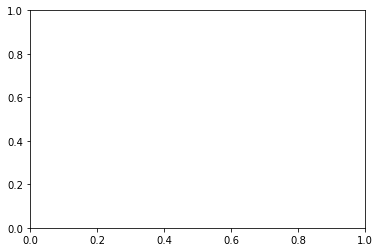

In [186]:
#loss for gamma0 values
loss_train = history.history['gamma0_output_loss']
loss_val = history.history['val_gamma0_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma1 values
loss_train = history.history['gamma1_output_loss']
loss_val = history.history['val_gamma1_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma2 values
loss_train = history.history['gamma2_output_loss']
loss_val = history.history['val_gamma2_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for logp1_si values
loss_train = history.history['logp1_si_output_loss']
loss_val = history.history['val_logp1_si_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp1_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#loss for logp2_si values
loss_train = history.history['logp2_si_output_loss']
loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp2_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()